In [1]:
import cv2

In [ ]:
https://ichi.pro/ko/opencvleul-sayonghayeo-tegseuteu-imijileul-jadong-eulo-giulgi-bojeong-ttogbalo-haneun-bangbeob-176759562404831

# OpenCV를 사용하여 텍스트 이미지를 자동으로 기울기 보정(똑바로)하는 방법

오늘 저는 이미지 기울기 보정 문제(회전된 이미지를 곧게 펴기)에 대한 간단한 솔루션을 공유하고자 합니다. 이미지에서 텍스트를 추출하는 작업을 하고 있다면 어떤 형태로든 이미지 기울기 보정을 처리해야 합니다. 카메라 사진에서 스캔한 문서까지 - 기울기 보정은 정리된 이미지를 OCR 도구에 공급하기 전에 이미지 사전 처리의 필수 단계입니다.

나 자신이 OpenCV 에서 이미지 처리를 배우고 실험하면서 대부분의 튜토리얼에서 논리에 대한 설명이 거의 없이 복사하여 붙여넣은 코드 솔루션을 얻을 수 있다는 것을 알게 되었습니다. 그것은 옳지 않다. 알고리즘을 이해하고 주어진 문제를 해결하기 위해 다양한 이미지 변환을 결합하는 방법을 이해해야 합니다. 그렇지 않으면 우리는 소프트웨어 엔지니어로서 어떤 진전도 이루지 못할 것입니다. 따라서 이 튜토리얼에서는 코드 조각을 최소한 으로 유지하고 작동하게 만드는 아이디어를 설명하는 데 집중할 것입니다. 하지만 걱정하지 마세요. 이 기사 끝에 있는 링크를 통해 내 GitHub 리포지토리에서 전체 코드를 항상 찾을 수 있습니다.

# 기울기 보정 알고리즘

기울기 보정 알고리즘의 일반적인 개념에 대해 논의하는 것으로 시작하겠습니다. 우리의 주요 목표는 회전된 이미지를 텍스트 블록으로 분할하고 각도를 결정하는 것입니다. 내가 사용할 접근 방식에 대한 자세한 설명은 다음과 같습니다.

  1) 평소에 — 이미지를 회색조로 변환합니다.
  2) 이미지의 노이즈를 줄이려면 약간의 흐림 효과를 적용합니다.
  3) 이제 우리의 목표는 텍스트가 있는 영역, 즉 이미지의 텍스트 블록을 찾는 것입니다. 텍스트 블록 감지를 더 쉽게 하기 위해 우리는 임계값을 통해 달성될 이미지의 색상을 반전하고 최대화할 것입니다. 이제 텍스트는 흰색(정확히 255,255,255 흰색)이 되고 배경은 검정색(동일 거래 0,0,0 검정색)이 됩니다.
  4) 텍스트 블록을 찾으려면 블록의 인쇄된 모든 문자를 병합해야 합니다. 팽창(흰색 픽셀 확장)을 통해 이를 달성합니다. X축에 더 큰 커널을 사용하여 단어 사이의 모든 공백을 제거하고 Y축에 더 작은 커널을 사용하여 서로 간에 한 블록의 줄을 혼합하지만 텍스트 블록 사이의 더 큰 공간은 그대로 유지합니다.
  5) 이제 윤곽선을 둘러싸는 최소 영역 직사각형으로 간단한 윤곽선 감지가 필요한 모든 텍스트 블록을 형성합니다.
  6) 기울이기 각도를 결정하는 방법에는 여러 가지가 있을 수 있지만 가장 큰 텍스트 블록을 가져와 각도를 사용하는 간단한 방법을 사용하겠습니다.

In [2]:
# Calculate skew angle of an image
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

  1) [Microsoft Azure Machine Learning x Udacity — 레슨 4 노트](https://ichi.pro/ko/microsoft-azure-machine-learning-x-udacity-leseun-4-noteu-188378422022695)

  2) [제품 관리자를 위한 AI, ML 및 딥 러닝의 기초](https://ichi.pro/ko/jepum-gwanlijaleul-wihan-ai-mlui-gicho-110121327605377)

  3) [데이터 과학 로드맵](https://ichi.pro/ko/deiteo-gwahagja-lodeumaeb-195561428391655)

  4) [인공 지능 프로젝트 작업](https://ichi.pro/ko/ingong-jineung-peulojegteu-jag-eob-112056663810310)

기울이기 각도를 얻은 후에는 이미지를 다시 회전하기만 하면 됩니다

In [ ]:
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

![image](./jpg/111.png)

이미지에 적용된 흐림 및 임계값

![image](./jpg/222.png)

텍스트 블록의 팽창 및 윤곽 감지

![image](./jpg/333.png)

가장 큰 텍스트 블록이 결정되고 최소 영역 직사각형으로 래핑됨

![image](./jpg/444.png)

기울어진 원본 이미지(왼쪽)와 기울어진 결과(오른쪽) 비교

# 각도 계산에 대한 참고 사항

귀하의 경우에는 가장 큰 블록을 사용하는 것보다 더 고급 계산이 필요할 수 있으며 실험을 시작할 수 있는 몇 가지 대체 전략이 있습니다.

1 — 모든 텍스트 블록의 평균 각도를 사용할 수 있습니다.

In [ ]:
allContourAngles = [cv2.minAreaRect(c)[-1] for c in contours]
angle = sum(allContourAngles) / len(allContourAngles)

In [ ]:
middleContour = contours[len(contours) // 2]
angle = cv2.minAreaRect(middleContour)[-1]

In [ ]:
largestContour = contours[0]
middleContour = contours[len(contours) // 2]
smallestContour = contours[-1]
angle = sum([cv2.minAreaRect(largestContour)[-1], cv2.minAreaRect(middleContour)[-1], cv2.minAreaRect(smallestContour)[-1]]) / 3

# 테스트

이 접근 방식을 테스트하기 위해 Lorem Ipsum 텍스트가 포함된 새로 생성된 PDF 파일을 사용했습니다. 이 문서의 첫 페이지는 300DPI 해상도(PDF 문서 작업 시 가장 일반적인 설정)로 렌더링되었습니다. 그 후 원본 이미지를 -10도에서 +10도 범위에서 무작위로 회전하여 20개의 샘플 이미지에 대한 테스트 데이터 세트를 생성했습니다. 그런 다음 기울이기 각도와 함께 이미지를 저장했습니다. 내 GitHub 리포지토리에서 이러한 샘플 이미지를 생성하는 데 사용된 모든 코드를 찾을 수 있습니다 . 여기서는 자세히 다루지 않겠습니다.

테스트 결과의 샘플 통계:

Item #0, with angle=1.77, calculated=1.77, difference=0.0%  
Item #1, with angle=-1.2, calculated=-1.19, difference=0.83%  
Item #2, with angle=8.92, calculated=8.92, difference=0.0%  
Item #3, with angle=8.68, calculated=8.68, difference=0.0%  
Item #4, with angle=4.83, calculated=4.82, difference=0.21%  
Item #5, with angle=4.41, calculated=4.4, difference=0.23%  
Item #6, with angle=-5.93, calculated=-5.91, difference=0.34%  
Item #7, with angle=-3.32, calculated=-3.33, difference=0.3%  
Item #8, with angle=6.53, calculated=6.54, difference=0.15%  
Item #9, with angle=-2.66, calculated=-2.65, difference=0.38%  
Item #10, with angle=-2.2, calculated=-2.19, difference=0.45%  
Item #11, with angle=-1.42, calculated=-1.4, difference=1.41%  
Item #12, with angle=-6.77, calculated=-6.77, difference=0.0%  
Item #13, with angle=-9.26, calculated=-9.25, difference=0.11%  
Item #14, with angle=4.36, calculated=4.35, difference=0.23%  
Item #15, with angle=5.49, calculated=5.48, difference=0.18%  
Item #16, with angle=-4.54, calculated=-4.55, difference=0.22%  
Item #17, with angle=-2.54, calculated=-2.54, difference=0.0%  
Item #18, with angle=4.65, calculated=4.66, difference=0.22%  
Item #19, with angle=-4.33, calculated=-4.32, difference=0.23%  
Min Error: 0.0%  
Max Error: 1.41%  
Avg Error: 0.27%  

![image](./jpg/555.png)

테스트 케이스 1

![image](./jpg/666.png)

테스트 케이스 2

오늘은 여기까지입니다! 내가 설명한 솔루션을 대부분의 기울기 보정 사례, 특히 스캔 문서 처리를 다루는 사례에 적용할 수 있습니다. 그러나 모든 문제는 고유하므로 이것을 출발점으로 삼고 이러한 기본 아이디어를 개선하십시오.

이 튜토리얼을 읽어주신 모든 분들께 감사드리며, 유용한 정보를 찾으셨기를 바랍니다. 행운을 빕니다!

소스 코드가 있는 GitHub 리포지토리:

----

In [2]:
import os

In [3]:
# D드라이브 로민 폴더 - train 폴더, test_samples 폴더

DATA_PATH = 'D:/coding/data_set/lomin/data'
os.listdir(DATA_PATH)

['test_samples', 'train']

In [4]:
# 이미지 폴더 경로

TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test_sampels')

In [ ]:
# 문서를 정방향으로 맞추기 위한 각도 (0~360)
# - 해당 각도로 회전된 문서

# 학습시 회전 시켜서 학습해야함. (pdf)

# Easy – 문서 자체 왜곡 없는, 
# hard – 왜곡 (구겨지거나 접힌 이미지)

# imgaug, albumentation 

# 이미지를 구기거나 찌그려 뜨리는 부분을 만들어서 학습해도 됨.

-----------

In [3]:
# test / val 나누기

# pip install split-folders

# https://pypi.org/project/split-folders/

import splitfolders

# splitfolders.ratio('데이터 경로', output="output folder 경로", seed=1337, ratio=(0.75, 0.15, 0.1))
# ratio = (train / val / test)
# ratio = (train / val) or (train / test)

DD = 'D:/coding/data_set/lomin'

splitfolders.ratio(DD, output='D:/coding/data_set/lomin/train_copy/', seed=1377, ratio=(0.8, 0.2))

# 9558 / 2390

"""
'데이터 경로' 폴더 안에 callss 폴더가 있어야 작동한다.

단일 class일 경우 '데이터 경로'폴더 안에 폴더를 한나 더 만들고 그 안에 이미지를 전부 넣고 실행

원본데이터에서 복사본들이 train/val 폴더로 각각 생성된다.

"""

"\n'데이터 경로' 폴더 안에 callss 폴더가 있어야 작동한다.\n\n단일 class일 경우 '데이터 경로'폴더 안에 폴더를 한나 더 만들고 그 안에 이미지를 전부 넣고 실행\n\n원본데이터에서 복사본들이 train/val 폴더로 각각 생성된다.\n\n"

In [4]:
# 파일 경로

train = 'D:/coding/data_set/lomin/train_copy/train'
val = 'D:/coding/data_set/lomin/train_copy/val'

print('train 이미지 : ', len(os.listdir(train)))
print('val 이미지 : ', len(os.listdir(val)))

train 이미지 :  9558
val 이미지 :  2390


In [39]:
# 이미지 증폭 (바운딩 박스 포함 증폭)

# pip install imgaug

# documentation
# https://imgaug.readthedocs.io/en/latest/source/installation.html

# git
# https://github.com/aleju/imgaug

In [40]:
# pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely

# Shapely 모듈 설치

In [38]:
sample_img = 'D:/coding/data_set/lomin/000000.png'

In [39]:
# 이미지 크기 확인

import cv2
import math

img = cv2.imread(sample_img)

print(type(img))
print(img.shape)
print(type(img.shape))
print()
h, w, c = img.shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

# 대각선 길이 2864.7
d = math.sqrt(h**2 + w**2)
print('diagonal : ', d)

# 회전 각 54.7도  (가로가 최대가 되는 각)
tan = math.degrees(math.atan(2339/1654)) # 탄젠트의 역함수
print('tan degree : ', tan)

# http://www.zhitov.ru/ko/diagonal/

<class 'numpy.ndarray'>
(2339, 1654, 3)
<class 'tuple'>

width:   1654
height:  2339
channel: 3
diagonal :  2864.7228487237644
tan degree :  54.73434898373184


In [48]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


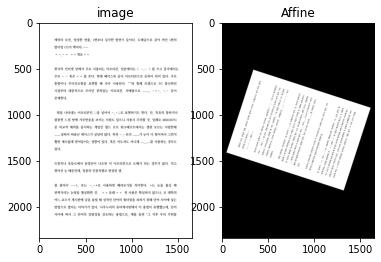

<Figure size 432x576 with 0 Axes>

In [51]:
# 이미지 회전
# https://076923.github.io/posts/Python-opencv-6/

import cv2
import matplotlib.pyplot as plt

src = cv2.imread(sample_img, cv2.IMREAD_COLOR)

height, width, channel = src.shape

my_angle = 72

##                                  중심점(center), 각도(angle), 비율(scale)
matrix = cv2.getRotationMatrix2D((width/2, height/2), my_angle, 0.57)
# 비율 : 가로길이 / 대각선

dst = cv2.warpAffine(src, matrix, (width, height))

# 변경 이미지 저장
cv2.imwrite('D:/coding/data_set/lomin/after/'+'000000'+'.png',dst)


# 이미지 화면에 출력하기
# cv2.imshow("src", src)
# cv2.imshow("dst", dst)
# cv2.waitKey()
# cv2.destroyAllWindows()

########### 

# 이미지 plt로 출력하기
plt.subplot(121),plt.imshow(img),plt.title('image')
plt.subplot(122),plt.imshow(dst),plt.title('Affine')
plt.figure(figsize=(6,8))
plt.show()


In [7]:
# 이미지 회전해서 저장하기 (1. 경로 설정)
import os
import cv2

DATA_PATH = 'D:/coding/data_set/lomin/train_copy'

TRAIN_PATH = os.path.join(DATA_PATH,'train')
VAL_PATH = os.path.join(DATA_PATH,'val')

In [9]:
import os
import glob
import cv2

test_path = 'D:/coding/data_set/lomin/temp_test/test' # test path

img_list = sorted(glob.glob(test_path + '/*'))

# 설정 각도에 따라 저장.
def lotation_img(my_angle):
    for i in img_list:
        # print(i.split('\\')[1].split('.')[0])
        src = cv2.imread(i, cv2.IMREAD_COLOR)
        height, width, channel = src.shape
        

        ##                                  중심점(center), 각도(angle), 비율(scale)
        matrix = cv2.getRotationMatrix2D((width/2, height/2), my_angle, 0.57)
        # 비율 : 가로길이 / 대각선

        dst = cv2.warpAffine(src, matrix, (width, height))

        # 변경 이미지 저장 (파일명_각도)
        cv2.imwrite('D:/coding/data_set/lomin/temp_test/test_after/' + i.split('\\')[1].split('.')[0] + '_' + str(my_angle) + '.png', dst)

In [97]:
lotation_img(0)

In [ ]:
# 이미지 스플릿 하기
# https://inhovation97.tistory.com/36

import os
import glob
import math
import shutil
import random

# 원본 이미지 폴더속 이미지 개수
doc_img = sorted(glob.glob('D:/coding/data_set/lomin/train_copy/train/'+'/*'))
print('doc_img 폴더 이미지 개수 : {}'.format(len(doc_img)))

# 나눌 이미지 수
doc_split = round(len(doc_img)*0.05)
print('doc_split : split 이미지 수 : {}'.format(doc_split))

# 이미지 나눌 모듈
def split(img_list, test_count, train_path, test_path):

    test_files=[]
    for i in random.sample( img_list, test_count ):
        test_files.append(i)
    
    # 차집합으로 train/test 리스트 생성하기
    train_files = [x for x in img_list if x not in test_files]

    for k in train_files:
        shutil.copy(k, train_path)

    for c in test_files:
        shutil.copy(c, test_path)

    print('train 폴더 이미지 개수 : {}\n test 폴더 이미지 개수 : {}'.format(len(glob.glob(train_path+'/*')), len(glob.glob(test_path+'/*'))))

doc_img 폴더 이미지 개수 : 9558
doc_split : split 이미지 수 : 478


In [ ]:
# 이미지를 

"""
이미지 전체 불러와서 train_a 폴더에 검은 테두리 추가해서 모두 저장 - 순환

바운딩 박스 생성 (포멧 알아봐야 함) 

회전시 바운딩 박스도 회전 시키는가, 아니면 각도만 알려주고 학습시키는가?
""" 

In [37]:
# Annotation 새로 만들기
#https://junyoung-jamong.github.io/machine/learning/2019/01/23/%EB%B0%94%EC%9A%B4%EB%94%A9%EB%B0%95%EC%8A%A4%EB%A5%BC-%ED%8F%AC%ED%95%A8%ED%95%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%A6%9D%ED%8F%AD%EC%8B%9C%ED%82%A4%EA%B8%B0-with-imgaug.html

# 바운딩박스 복붙 (Annotation정보 읽기)

import xml.etree.ElementTree as ET

# 이미지 주소
test_img_path = 'D:/coding/data_set/lomin/temp_test/test_after/'

# 폴더 내 이미지 리스트
img_list = sorted(glob.glob(test_img_path + '/*'))

# Annotation 반복 만들기
for i in img_list:
	File = open(test_img_path + i.split('\\')[1].split('.')[0] + ".xml", "w")
	print("""<annotation>
	<folder>test_after</folder>
	<filename>{}.png</filename>
	<path>D:\coding\data_set\lomin\\temp_test\\test_after\\{}.png</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1654</width>
		<height>2339</height>
		<depth>1</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>doc</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>355</xmin>
			<ymin>503</ymin>
			<xmax>1299</xmax>
			<ymax>1836</ymax>
		</bndbox>
	</object>
</annotation>
	""".format(i.split('\\')[1].split('.')[0], i.split('\\')[1].split('.')[0]), file=File)

	File.close()